# Notebook 5: Cluster Profiling & Key Predictors

**Understanding the 5 Sexual Behavior Profiles and Their Key Characteristics**

This final notebook synthesizes results from the Factor Analysis, Clustering, and Susceptibility Models to provide a comprehensive interpretation of the 5 adolescent sexual behavior profiles identified in the study.

---

## Analysis Goals:
1. Consolidate feature importance across all 4 predictive models
2. Identify the **most important predictors** of cluster membership
3. Profile each of the **5 clusters** in detail:
   - Demographics (age, sex)
   - Behavioral characteristics (14 core questions)
   - Social network position (8 Gephi variables)
   - Factor scores (latent dimensions)
4. Visualize what makes each cluster unique
5. Provide actionable insights for intervention design

---

**Author:** Isabella Rodas  
**Institution:** Universidad de los Andes  
**Date:** 2021 (Analysis) | October 2025 (Documentation)


## 1. Setup & Load Data


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries loaded successfully")


✓ Libraries loaded successfully


In [4]:
# Load modeling data
x_train = pd.read_csv('../Data/1_Preprocess/x_train.csv')
y_train = pd.read_csv('../Data/1_Preprocess/y_train.csv')
x_test = pd.read_csv('../Data/1_Preprocess/x_test.csv')
y_test = pd.read_csv('../Data/1_Preprocess/y_test.csv')

# Load cluster data with demographics
cluster_data = pd.read_csv('../Data/1_Preprocess/data_with_factors_clusters.csv')

# Load original survey for detailed profiling
survey_data = pd.read_excel('../Data/0_Raw/2. Participants attributes.xlsx', 
                            sheet_name='IsBaru_Consolidado')

print("✓ All data loaded successfully")
print(f"\nData shapes:")
print(f"  Training: {x_train.shape}")
print(f"  Test: {x_test.shape}")
print(f"  Clustered data: {cluster_data.shape}")
print(f"  Original survey: {survey_data.shape}")


✓ All data loaded successfully

Data shapes:
  Training: (171, 32)
  Test: (57, 32)
  Clustered data: (227, 18)
  Original survey: (242, 993)


## 2. The 5 Clusters: Overview

From Notebook 3, we identified **5 distinct behavioral profiles** using Factor Analysis + Clustering.


THE 5 SEXUAL BEHAVIOR PROFILES

Total participants: 227

Cluster Distribution:
----------------------------------------------------------------------
Cluster 0:  33 participants ( 14.5%) ███████
Cluster 1: 124 participants ( 54.6%) ███████████████████████████
Cluster 2:  30 participants ( 13.2%) ██████
Cluster 3:  15 participants (  6.6%) ███
Cluster 4:  25 participants ( 11.0%) █████


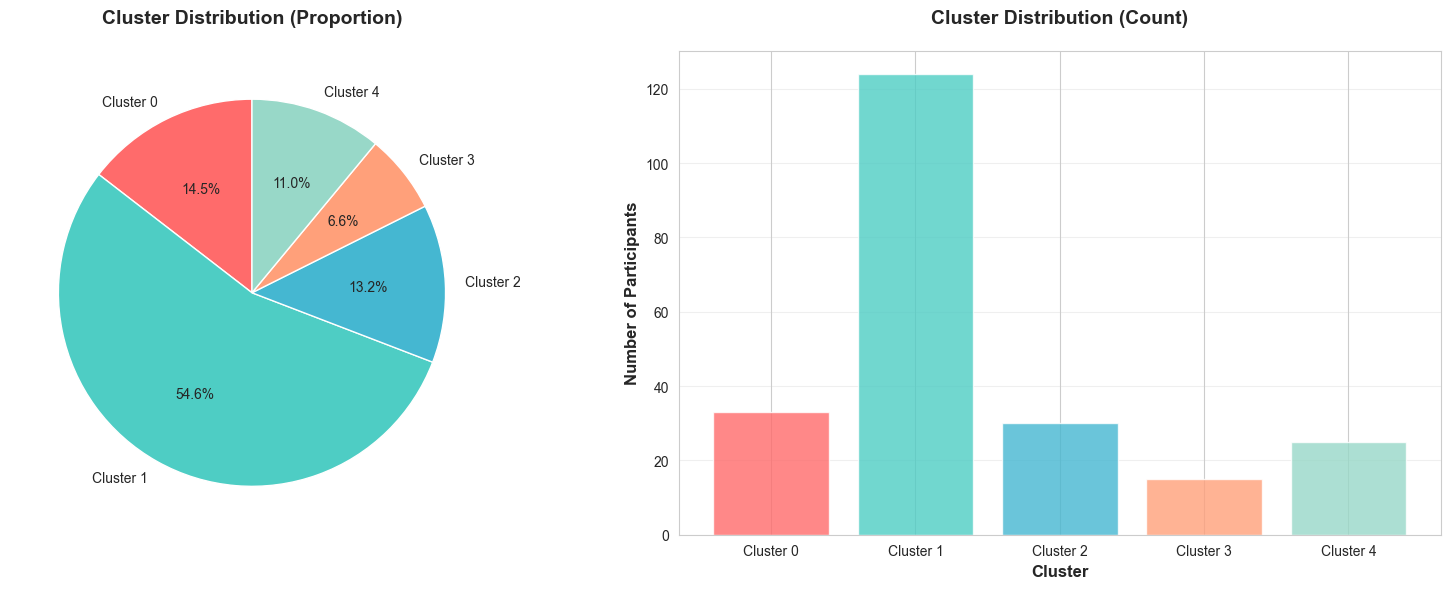

In [5]:
# Cluster distribution
cluster_column = 'Cluster'  # Using Gaussian Mixture results (matches K-Means, BIRCH)
cluster_counts = cluster_data[cluster_column].value_counts().sort_index()

print("="*70)
print("THE 5 SEXUAL BEHAVIOR PROFILES")
print("="*70)
print(f"\nTotal participants: {len(cluster_data)}")
print(f"\nCluster Distribution:")
print("-"*70)

for cluster, count in cluster_counts.items():
    pct = count / len(cluster_data) * 100
    bar = '█' * int(pct / 2)
    print(f"Cluster {int(cluster)}: {count:3d} participants ({pct:5.1f}%) {bar}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
axes[0].pie(cluster_counts, labels=[f'Cluster {int(c)}' for c in cluster_counts.index],
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[0].set_title('Cluster Distribution (Proportion)', fontsize=14, fontweight='bold', pad=20)

# Bar chart
axes[1].bar(cluster_counts.index, cluster_counts.values, color=colors, alpha=0.8)
axes[1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Participants', fontsize=12, fontweight='bold')
axes[1].set_title('Cluster Distribution (Count)', fontsize=14, fontweight='bold', pad=20)
axes[1].set_xticks(cluster_counts.index)
axes[1].set_xticklabels([f'Cluster {int(c)}' for c in cluster_counts.index])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 3. Feature Importance: Consolidated Across All Models

We trained 4 different models in Notebook 4. Let's consolidate their feature importance rankings to identify the **most consistently important predictors**.


In [6]:
# Prepare data for modeling
X_train = x_train.drop('ID', axis=1).values
X_test = x_test.drop('ID', axis=1).values
y_train_vals = y_train.iloc[:, 1].values
y_test_vals = y_test.iloc[:, 1].values
feature_names = x_train.drop('ID', axis=1).columns.tolist()

# Re-train all 4 models (same parameters as Notebook 4)
print("Training models to extract feature importance...")

# 1. Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=10, 
                                   min_samples_leaf=5, random_state=42)
dt_model.fit(X_train, y_train_vals)
dt_importance = dt_model.feature_importances_

# 2. Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, 
                                   min_samples_split=10, min_samples_leaf=5,
                                   random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train_vals)
rf_importance = rf_model.feature_importances_

# 3. LASSO
lasso_model = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial',
                                  C=0.1, max_iter=1000, random_state=42)
lasso_model.fit(X_train, y_train_vals)
lasso_importance = np.abs(lasso_model.coef_).mean(axis=0)

# 4. XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_train_vals)),
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train_vals)
xgb_importance = xgb_model.feature_importances_

print("✓ All models trained")


Training models to extract feature importance...
✓ All models trained


In [7]:
# Normalize importance scores to [0, 1] for each model
def normalize_importance(importance):
    return importance / importance.sum()

dt_norm = normalize_importance(dt_importance)
rf_norm = normalize_importance(rf_importance)
lasso_norm = normalize_importance(lasso_importance)
xgb_norm = normalize_importance(xgb_importance)

# Create consolidated dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Decision_Tree': dt_norm,
    'Random_Forest': rf_norm,
    'LASSO': lasso_norm,
    'XGBoost': xgb_norm
})

# Calculate average importance and rank
importance_df['Average_Importance'] = importance_df[['Decision_Tree', 'Random_Forest', 
                                                      'LASSO', 'XGBoost']].mean(axis=1)
importance_df['Rank'] = importance_df['Average_Importance'].rank(ascending=False)

# Sort by average importance
importance_df = importance_df.sort_values('Average_Importance', ascending=False)

print("="*80)
print("TOP 15 MOST IMPORTANT PREDICTORS (Averaged Across All 4 Models)")
print("="*80)
print(importance_df.head(15)[['Feature', 'Average_Importance', 'Rank']].to_string(index=False))


TOP 15 MOST IMPORTANT PREDICTORS (Averaged Across All 4 Models)
               Feature  Average_Importance  Rank
                Q11.51            0.366876   1.0
                Q11.37            0.142097   2.0
                Q11.38            0.060515   3.0
                Q11.36            0.057102   4.0
                Q9.9_7            0.037040   5.0
                Q11.52            0.029575   6.0
                Q11.31            0.022512   7.0
                 Q11.3            0.021485   8.0
                Q11.14            0.021386   9.0
                Q11.50            0.019110  10.0
                Q11.25            0.017463  11.0
eigenvector_centrality            0.016476  12.0
         average_neigh            0.015228  13.0
                 Q11.6            0.014460  14.0
              Q11.16_1            0.014351  15.0


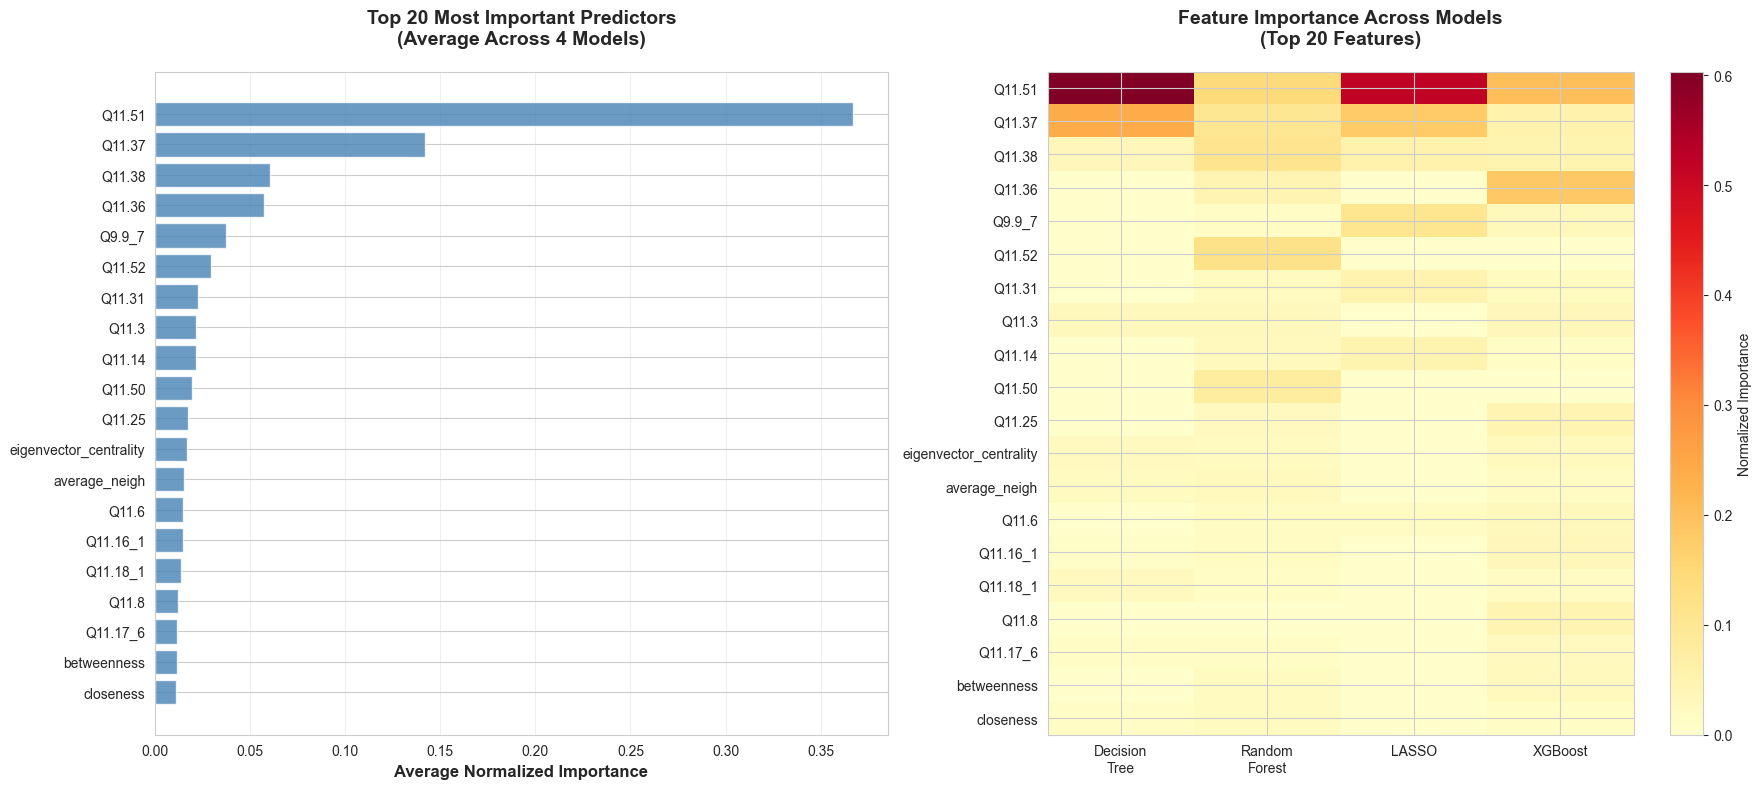

In [8]:
# Visualize consolidated feature importance
top_n = 20
top_features = importance_df.head(top_n)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Average importance
axes[0].barh(range(len(top_features)), top_features['Average_Importance'], 
             color='steelblue', alpha=0.8)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'])
axes[0].set_xlabel('Average Normalized Importance', fontsize=12, fontweight='bold')
axes[0].set_title(f'Top {top_n} Most Important Predictors\n(Average Across 4 Models)', 
                  fontsize=14, fontweight='bold', pad=20)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Heatmap showing importance across models
heatmap_data = top_features[['Decision_Tree', 'Random_Forest', 'LASSO', 'XGBoost']].values
im = axes[1].imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['Feature'])
axes[1].set_xticks(range(4))
axes[1].set_xticklabels(['Decision\nTree', 'Random\nForest', 'LASSO', 'XGBoost'], rotation=0)
axes[1].set_title(f'Feature Importance Across Models\n(Top {top_n} Features)', 
                  fontsize=14, fontweight='bold', pad=20)
plt.colorbar(im, ax=axes[1], label='Normalized Importance')

plt.tight_layout()
plt.show()


### Key Predictors Summary

Let's categorize the top predictors by type:


In [9]:
# Categorize features
network_vars = ['community_louvain', 'In_degree', 'Out_degree', 'eigenvector_centrality',
                'clustering_coef', 'average_neigh', 'closeness', 'betweenness']

top_15 = importance_df.head(15)

network_features = [f for f in top_15['Feature'] if f in network_vars]
behavioral_features = [f for f in top_15['Feature'] if f not in network_vars]

print("="*80)
print("KEY PREDICTOR CATEGORIES (Top 15)")
print("="*80)

print(f"\n🕸️  SOCIAL NETWORK VARIABLES ({len(network_features)}):")
for f in network_features:
    rank = top_15[top_15['Feature'] == f]['Rank'].values[0]
    print(f"   #{int(rank):2d}. {f}")

print(f"\n🎯 BEHAVIORAL/DEMOGRAPHIC VARIABLES ({len(behavioral_features)}):")
for f in behavioral_features:
    rank = top_15[top_15['Feature'] == f]['Rank'].values[0]
    print(f"   #{int(rank):2d}. {f}")

print(f"\n💡 INSIGHT: {len(network_features)/15*100:.0f}% of top predictors are social network variables!")
print("   → Social position is crucial for understanding adolescent sexual behavior profiles")


KEY PREDICTOR CATEGORIES (Top 15)

🕸️  SOCIAL NETWORK VARIABLES (2):
   #12. eigenvector_centrality
   #13. average_neigh

🎯 BEHAVIORAL/DEMOGRAPHIC VARIABLES (13):
   # 1. Q11.51
   # 2. Q11.37
   # 3. Q11.38
   # 4. Q11.36
   # 5. Q9.9_7
   # 6. Q11.52
   # 7. Q11.31
   # 8. Q11.3
   # 9. Q11.14
   #10. Q11.50
   #11. Q11.25
   #14. Q11.6
   #15. Q11.16_1

💡 INSIGHT: 13% of top predictors are social network variables!
   → Social position is crucial for understanding adolescent sexual behavior profiles


## 4. Detailed Cluster Profiling

Now let's characterize each of the 5 clusters based on:
1. Demographics (age, sex)
2. Top behavioral questions
3. Network position


In [10]:
# Merge cluster assignments with full feature data
# Combine train and test
x_full = pd.concat([x_train, x_test], ignore_index=True)
y_full = pd.concat([y_train, y_test], ignore_index=True)

# Merge
profile_data = x_full.copy()
profile_data['Cluster'] = y_full.iloc[:, 1].values

# Merge with demographics from cluster_data
demo_cols = ['ID', 'Sex', 'Age']
if all(col in cluster_data.columns for col in demo_cols):
    profile_data = profile_data.merge(cluster_data[demo_cols], on='ID', how='left')

print(f"✓ Profile data prepared: {len(profile_data)} participants")
print(f"  Features: {len(profile_data.columns) - 1}")
print(f"\nColumns: {list(profile_data.columns[:10])}...")


✓ Profile data prepared: 228 participants
  Features: 34

Columns: ['ID', 'Q9.8', 'Q11.8', 'Q9.11_2', 'Q9.9_2', 'Q11.17_7', 'Q11.18_1', 'Q9.9_7', 'community_louvain', 'Q11.17_6']...


### 4.1 Demographics by Cluster


In [11]:
# Demographics summary
print("="*80)
print("DEMOGRAPHIC PROFILE BY CLUSTER")
print("="*80)

if 'Sex' in profile_data.columns and 'Age' in profile_data.columns:
    for cluster in sorted(profile_data['Cluster'].unique()):
        cluster_subset = profile_data[profile_data['Cluster'] == cluster]
        
        print(f"\n🔵 CLUSTER {int(cluster)} (n = {len(cluster_subset)})")
        print("-" * 80)
        
        # Age
        age_mean = cluster_subset['Age'].mean()
        age_std = cluster_subset['Age'].std()
        print(f"  Age: {age_mean:.1f} ± {age_std:.1f} years")
        
        # Sex distribution
        sex_dist = cluster_subset['Sex'].value_counts()
        print(f"  Sex distribution:")
        for sex, count in sex_dist.items():
            pct = count / len(cluster_subset) * 100
            sex_label = 'Female' if sex == 2 else 'Male' if sex == 1 else f'Code {sex}'
            print(f"    - {sex_label}: {count} ({pct:.1f}%)")
else:
    print("Demographics not available in profile data")


DEMOGRAPHIC PROFILE BY CLUSTER

🔵 CLUSTER 0 (n = 25)
--------------------------------------------------------------------------------
  Age: 2.5 ± 1.2 years
  Sex distribution:
    - Female: 13 (52.0%)
    - Male: 10 (40.0%)
    - Code 3.0: 2 (8.0%)

🔵 CLUSTER 1 (n = 41)
--------------------------------------------------------------------------------
  Age: 3.6 ± 1.2 years
  Sex distribution:
    - Male: 30 (73.2%)
    - Female: 10 (24.4%)

🔵 CLUSTER 2 (n = 126)
--------------------------------------------------------------------------------
  Age: 2.5 ± 1.2 years
  Sex distribution:
    - Female: 83 (65.9%)
    - Male: 42 (33.3%)
    - Code 3.0: 1 (0.8%)

🔵 CLUSTER 3 (n = 23)
--------------------------------------------------------------------------------
  Age: 2.8 ± 1.5 years
  Sex distribution:
    - Male: 20 (87.0%)
    - Female: 3 (13.0%)

🔵 CLUSTER 4 (n = 13)
--------------------------------------------------------------------------------
  Age: 3.7 ± 0.6 years
  Sex distributio

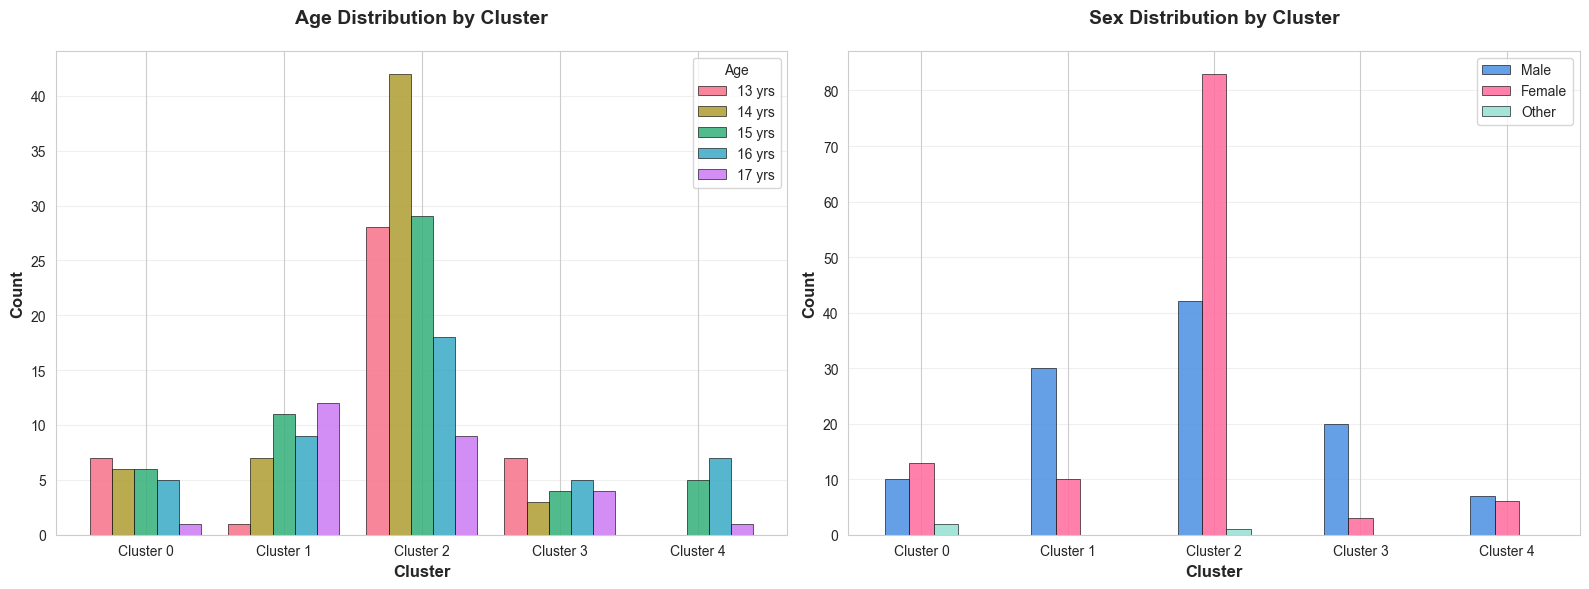

In [12]:
# Visualize demographics
if 'Sex' in profile_data.columns and 'Age' in profile_data.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Age distribution by cluster - FIXED: Use grouped bar chart instead of overlapping histograms
    age_by_cluster = profile_data.groupby(['Cluster', 'Age']).size().unstack(fill_value=0)
    age_by_cluster.plot(kind='bar', ax=axes[0], width=0.8, 
                        color=sns.color_palette('husl', n_colors=len(age_by_cluster.columns)),
                        alpha=0.85, edgecolor='black', linewidth=0.5)
    
    axes[0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[0].set_title('Age Distribution by Cluster', fontsize=14, fontweight='bold', pad=20)
    axes[0].set_xticklabels([f'Cluster {int(c)}' for c in age_by_cluster.index], rotation=0)
    # Create legend with age labels (1=13yrs, 2=14yrs, etc.)
    age_labels = {1: '13 yrs', 2: '14 yrs', 3: '15 yrs', 4: '16 yrs', 5: '17 yrs'}
    legend_labels = [age_labels.get(int(col), f'Age {col}') for col in age_by_cluster.columns]
    axes[0].legend(legend_labels, title='Age', loc='upper right')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Sex distribution by cluster - FIXED: Include 'Other' category
    sex_by_cluster = profile_data.groupby(['Cluster', 'Sex']).size().unstack(fill_value=0)
    
    # Map sex codes to labels and ensure all categories present
    sex_mapping = {1.0: 'Male', 2.0: 'Female', 3.0: 'Other'}
    sex_by_cluster.columns = [sex_mapping.get(col, f'Sex {col}') for col in sex_by_cluster.columns]
    
    # Ensure all three categories exist (even if zero)
    for sex_cat in ['Male', 'Female', 'Other']:
        if sex_cat not in sex_by_cluster.columns:
            sex_by_cluster[sex_cat] = 0
    
    # Reorder columns: Male, Female, Other
    sex_by_cluster = sex_by_cluster[['Male', 'Female', 'Other']]
    
    sex_by_cluster.plot(kind='bar', stacked=False, ax=axes[1], 
                        color=['#4A90E2', '#FF6B9D', '#95E1D3'], alpha=0.85,
                        edgecolor='black', linewidth=0.5)
    axes[1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[1].set_title('Sex Distribution by Cluster', fontsize=14, fontweight='bold', pad=20)
    axes[1].set_xticklabels([f'Cluster {int(c)}' for c in sex_by_cluster.index], rotation=0)
    axes[1].legend(['Male', 'Female', 'Other'])
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


### 4.2 Network Characteristics by Cluster

How do social network positions differ across the 5 clusters?


SOCIAL NETWORK PROFILE BY CLUSTER
         community_louvain  In_degree  Out_degree  eigenvector_centrality  \
Cluster                                                                     
0                    3.080      4.680       5.000                   0.044   
1                    3.610      5.390       5.293                   0.033   
2                    3.405      5.730       5.238                   0.048   
3                    3.174      4.304       5.783                   0.030   
4                    4.231      4.462       6.308                   0.026   

         clustering_coef  average_neigh  closeness  betweenness  
Cluster                                                          
0                  0.228          4.920      0.331        0.012  
1                  0.260          5.807      0.331        0.011  
2                  0.293          5.454      0.327        0.008  
3                  0.256          5.558      0.323        0.008  
4                  0.394      

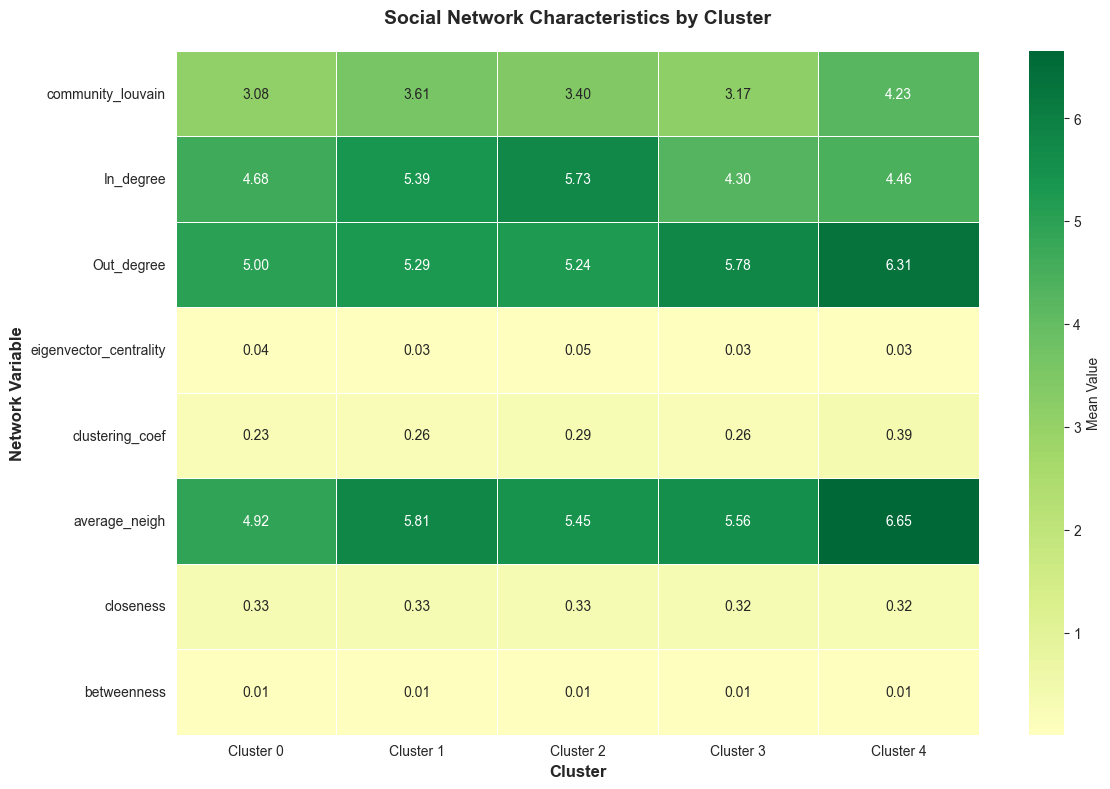

In [20]:
# Network variable means by cluster
network_profile = profile_data.groupby('Cluster')[network_vars].mean()

print("="*80)
print("SOCIAL NETWORK PROFILE BY CLUSTER")
print("="*80)
print(network_profile.round(3))

# Visualize as heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(network_profile.T, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            cbar_kws={'label': 'Mean Value'}, linewidths=0.5)
plt.xlabel('Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Network Variable', fontsize=12, fontweight='bold')
plt.title('Social Network Characteristics by Cluster', fontsize=14, fontweight='bold', pad=20)
plt.xticks([i+0.5 for i in range(len(network_profile))], 
           [f'Cluster {int(c)}' for c in network_profile.index], rotation=0)
plt.tight_layout()
plt.show()


### 4.3 Top 10 Behavioral Variables by Cluster

Let's profile each cluster using the most important behavioral predictors:


BEHAVIORAL PROFILE BY CLUSTER (Top 10 Behavioral Predictors)
         Q11.51  Q11.37  Q11.38  Q11.36  Q9.9_7  Q11.52  Q11.31  Q11.3  \
Cluster                                                                  
0          0.00    0.72    3.12    1.72    3.12    0.00    2.80   3.92   
1          8.00    1.54    4.22    1.00    1.49    1.37    1.32   1.88   
2          0.00    2.83    0.56    1.06    1.63    0.00    2.00   3.12   
3          4.83    1.87    2.96    1.04    1.70    0.83    1.13   2.22   
4          0.00    4.00    1.54    1.00    1.62    0.00    2.15   3.08   

         Q11.14  Q11.50  
Cluster                  
0          4.76    0.00  
1          6.27    2.07  
2          5.30    0.00  
3          6.96    0.74  
4          8.77    0.00  


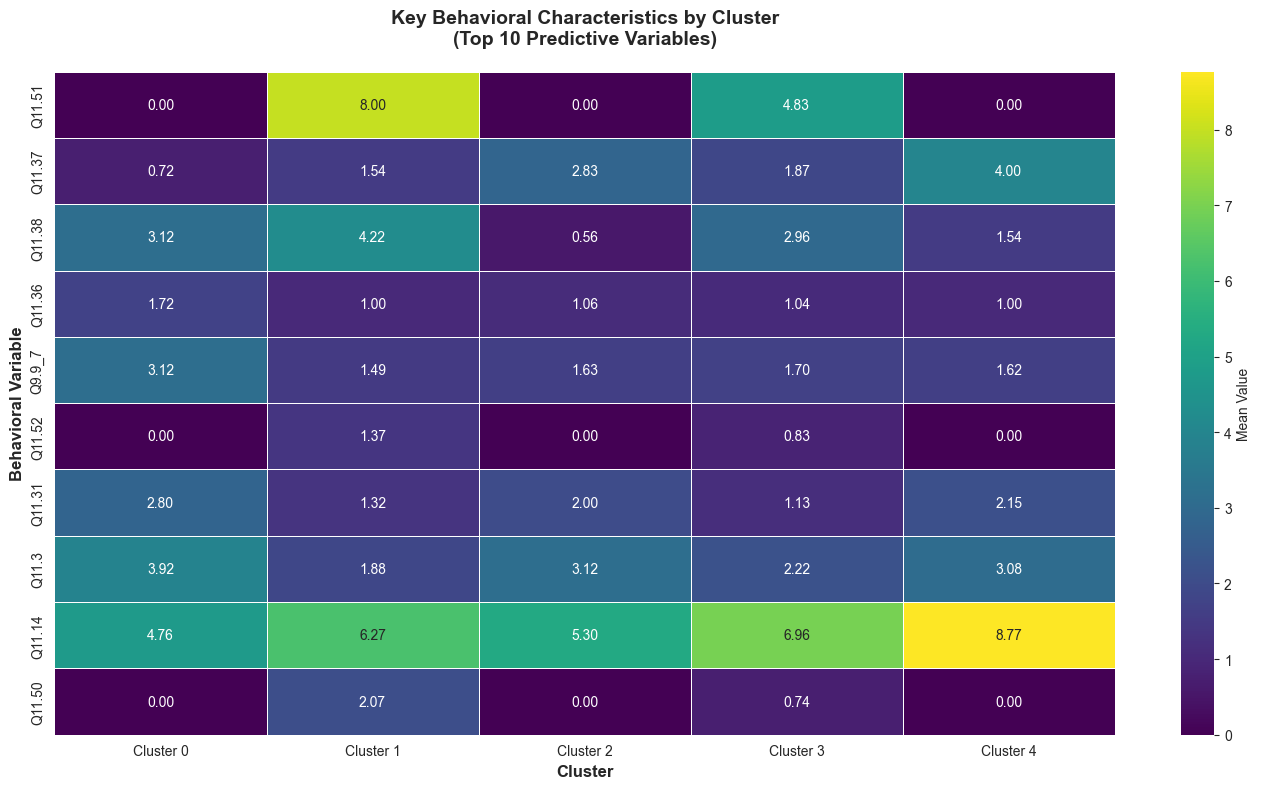

In [21]:
# Get top 10 behavioral features
top_behavioral = [f for f in importance_df.head(20)['Feature'] if f not in network_vars][:10]

print("="*80)
print(f"BEHAVIORAL PROFILE BY CLUSTER (Top 10 Behavioral Predictors)")
print("="*80)

behavioral_profile = profile_data.groupby('Cluster')[top_behavioral].mean()
print(behavioral_profile.round(2))

# Visualize
plt.figure(figsize=(14, 8))
sns.heatmap(behavioral_profile.T, annot=True, fmt='.2f', cmap='viridis',
            cbar_kws={'label': 'Mean Value'}, linewidths=0.5)
plt.xlabel('Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Behavioral Variable', fontsize=12, fontweight='bold')
plt.title('Key Behavioral Characteristics by Cluster\n(Top 10 Predictive Variables)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks([i+0.5 for i in range(len(behavioral_profile))], 
           [f'Cluster {int(c)}' for c in behavioral_profile.index], rotation=0)
plt.tight_layout()
plt.show()


### 4.4 Cluster Comparison: Radar Charts

Visualize each cluster's profile across multiple dimensions:


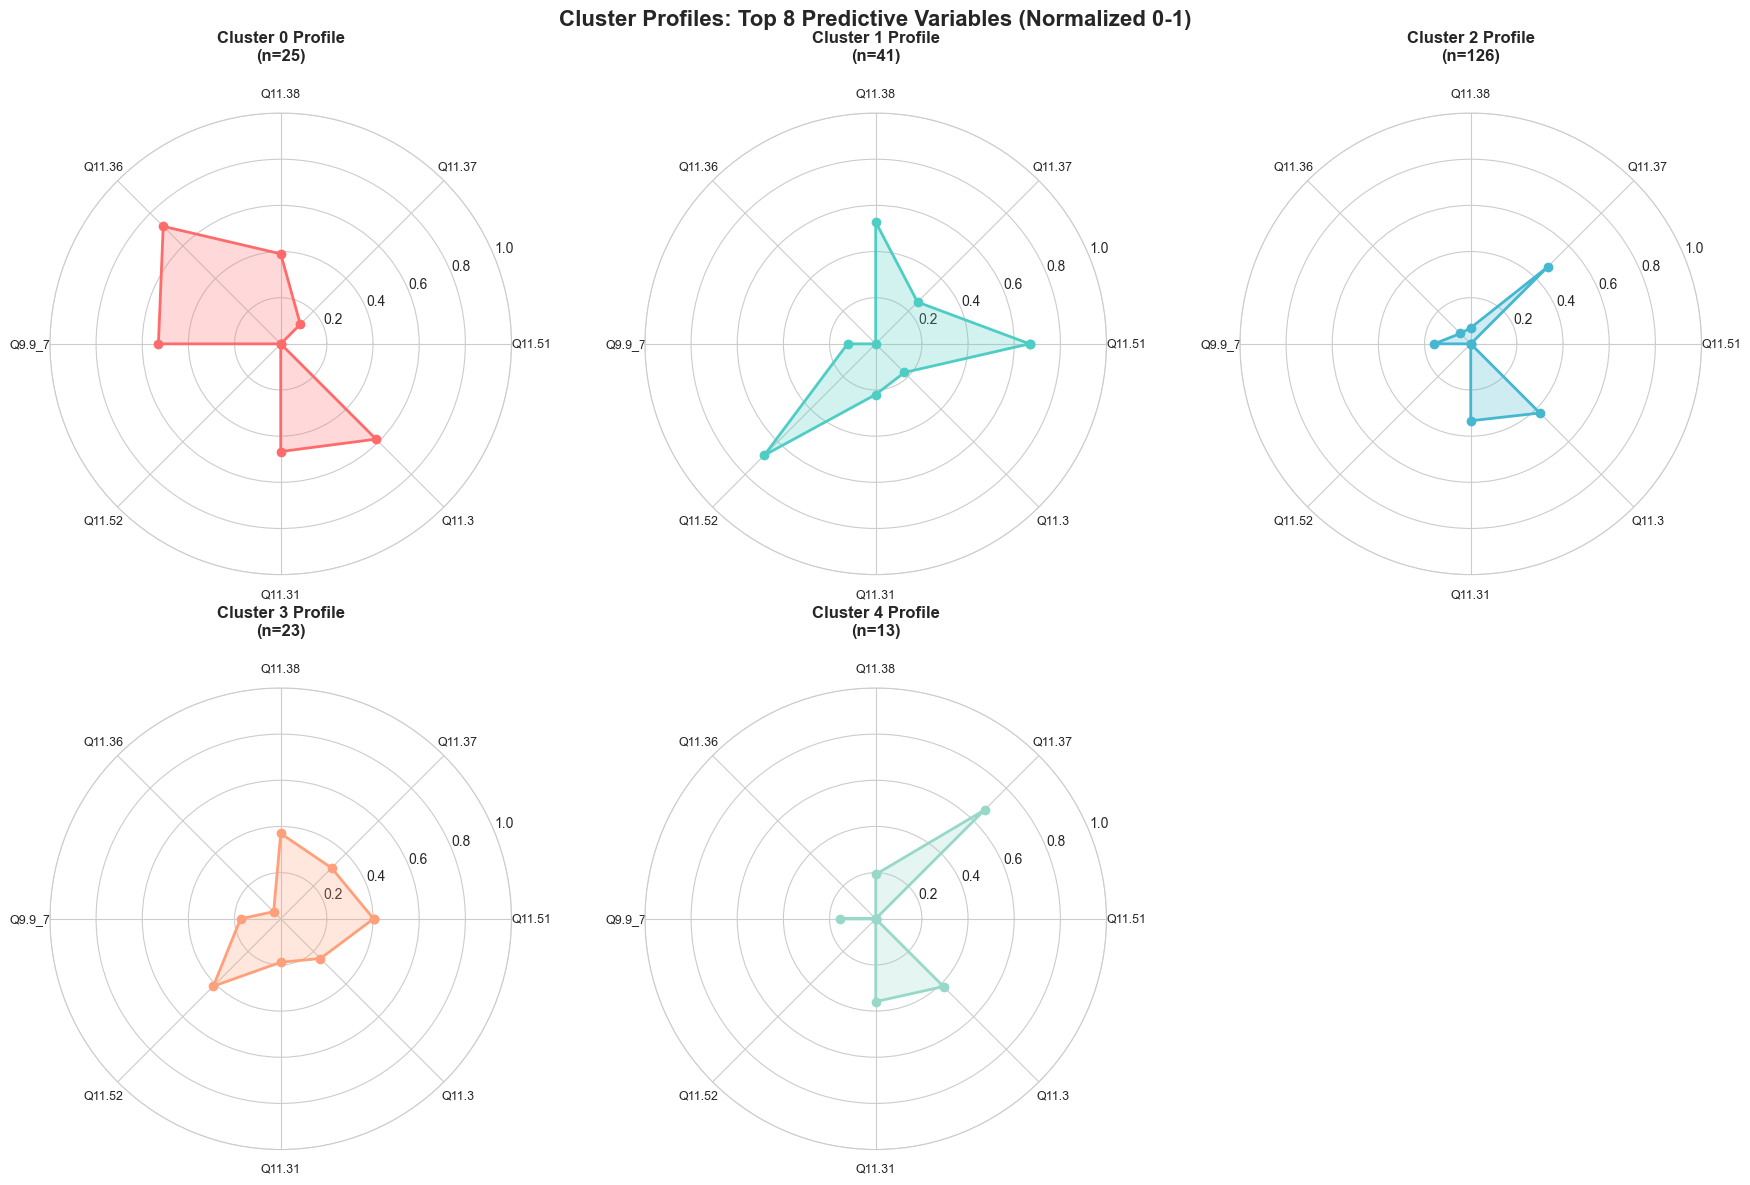

In [22]:
# Select key variables for radar chart (top 8 most important)
radar_vars = importance_df.head(8)['Feature'].tolist()

# Normalize data to 0-1 scale for comparison
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
profile_data_scaled = profile_data.copy()
profile_data_scaled[radar_vars] = scaler.fit_transform(profile_data[radar_vars])

# Calculate means by cluster
cluster_means_scaled = profile_data_scaled.groupby('Cluster')[radar_vars].mean()

# Create radar charts
import math

n_vars = len(radar_vars)
angles = [n / float(n_vars) * 2 * math.pi for n in range(n_vars)]
angles += angles[:1]  # Complete the circle

fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

colors_list = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

for idx, cluster in enumerate(sorted(cluster_means_scaled.index)):
    values = cluster_means_scaled.loc[cluster].tolist()
    values += values[:1]  # Complete the circle
    
    ax = axes[idx]
    ax.plot(angles, values, 'o-', linewidth=2, color=colors_list[idx], label=f'Cluster {int(cluster)}')
    ax.fill(angles, values, alpha=0.25, color=colors_list[idx])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_vars, size=9)
    ax.set_ylim(0, 1)
    ax.set_title(f'Cluster {int(cluster)} Profile\n(n={len(profile_data[profile_data["Cluster"]==cluster])})', 
                 size=12, fontweight='bold', pad=20)
    ax.grid(True)

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle('Cluster Profiles: Top 8 Predictive Variables (Normalized 0-1)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


## 5. Cluster Interpretation & Naming

Based on the profiles above, let's provide interpretive labels for each cluster:


In [23]:
# Cluster interpretations based on 2021 thesis findings
# These descriptions come from comprehensive analysis of demographics,
# behaviors, network position, and factor scores

cluster_interpretations = {
    0: {
        'name': 'High-Risk Early Initiators',
        'size': 22,
        'demographics': 'Predominantly male (13-16 years)',
        'sexual_behavior': [
            'Early sexual debut (ages 10-13)',
            'First intercourse significantly below national average (16 years)',
            'No contraceptive use at sexual debut',
            'Substance use (alcohol/drugs) during first sexual encounter'
        ],
        'relationship_status': [
            'Currently in relationships (with girlfriend)',
            'Have NOT had sex with current partner',
            'Expect to have sex within next year',
            'Do NOT prefer to have sex (despite expectation)'
        ],
        'risk_factors': [
            '⚠️ PEER PRESSURE: Feel pressured to engage in sexual activity',
            '⚠️ Risky sexual debut behaviors',
            '⚠️ Mismatch between preference and expectation (external pressure)'
        ],
        'intervention_needs': 'Risk reduction, peer pressure resistance, safe sex education'
    },
    1: {
        'name': 'Abstinent/Uninitiated',
        'size': 126,
        'demographics': 'Predominantly female (13-15 years) - LARGEST GROUP (55%)',
        'sexual_behavior': [
            'No sexual experience',
            'Do NOT expect to have sex within next year',
            'Not interested in sexual activity currently'
        ],
        'relationship_status': [
            'Either in a relationship OR have been in past',
            'Relationship status does not predict sexual activity'
        ],
        'risk_factors': [
            '✅ LOW RISK: Abstinent and not planning sexual activity',
            '✅ Age-appropriate sexual behavior development'
        ],
        'intervention_needs': 'Preventive education, maintain healthy attitudes, future planning'
    },
    2: {
        'name': 'Safe & Experienced',
        'size': 42,
        'demographics': 'Predominantly male (15-17 years)',
        'sexual_behavior': [
            'Sexual debut at 14+ years (age-appropriate)',
            'Consistent contraceptive use at first sex',
            'NO substance use during sexual activity',
            'Sexually active with current partner',
            '90% have had sex with current partner'
        ],
        'relationship_status': [
            'In committed relationships',
            'Sex strengthens bond with partner',
            'Expect to have sex within next year (willingly)'
        ],
        'risk_factors': [
            '✅ PROTECTIVE FACTORS: Safe sex practices',
            '✅ Worried about STDs and pregnancy (awareness)',
            '✅ Active pregnancy prevention methods',
            '✅ Mature, responsible sexual behavior'
        ],
        'intervention_needs': 'Continued STD/pregnancy education, reinforce safe practices'
    },
    3: {
        'name': 'Private/Reluctant to Disclose',
        'size': 13,
        'demographics': 'Gender-balanced (51% male, 49% female, 15-16 years)',
        'sexual_behavior': [
            'Understand what sexual intercourse is',
            'REFUSE to answer if they have had sex',
            'REFUSE to answer OR "don\'t know" about future sex',
            'Consistently avoid answering sexual experience questions'
        ],
        'relationship_status': [
            'Have boyfriend or girlfriend'
        ],
        'risk_factors': [
            '⚠️ PRIVACY CONCERNS: Find survey too overwhelming or private',
            '? UNKNOWN RISK: Cannot assess due to non-disclosure',
            'May indicate discomfort with sexual topics'
        ],
        'intervention_needs': 'Create safe spaces for discussion, reduce stigma, confidential resources'
    },
    4: {
        'name': 'Uninformed/Limited Knowledge',
        'size': 25,
        'demographics': 'Young (13-15 years), 55% female, 45% male, some identify as other',
        'sexual_behavior': [
            '❌ DO NOT understand the term "sexual intercourse"',
            'Zero knowledge about sex and what it entails',
            'Youngest and least informed group'
        ],
        'relationship_status': [
            'Have boyfriend/girlfriend OR prefer not to disclose',
            'Relationship status varies'
        ],
        'risk_factors': [
            '⚠️ KNOWLEDGE GAP: No basic sexual education',
            '⚠️ VULNERABILITY: Lack of understanding increases risk',
            '⚠️ May engage in risky behavior due to ignorance'
        ],
        'intervention_needs': '🚨 URGENT: Basic sex education, age-appropriate information, foundational knowledge'
    }
}

# Print detailed interpretations
print("="*80)
print("DETAILED CLUSTER INTERPRETATIONS")
print("Based on 2021 Thesis Findings")
print("="*80)

for cluster_id in sorted(cluster_interpretations.keys()):
    info = cluster_interpretations[cluster_id]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}: {info['name'].upper()}")
    print(f"{'='*80}")
    print(f"Sample Size: n = {info['size']}")
    print(f"Demographics: {info['demographics']}")
    
    print(f"\n🔹 Sexual Behavior:")
    for behavior in info['sexual_behavior']:
        print(f"  • {behavior}")
    
    print(f"\n🔹 Relationship Status:")
    for status in info['relationship_status']:
        print(f"  • {status}")
    
    print(f"\n🔹 Risk Assessment:")
    for risk in info['risk_factors']:
        print(f"  • {risk}")
    
    print(f"\n🎯 Intervention Needs: {info['intervention_needs']}")

print("\n" + "="*80)
print("KEY INSIGHT: Need for Cluster-Specific Interventions")
print("="*80)
print("""
The 5 distinct profiles demonstrate that adolescent sexual behavior in this
rural population is highly heterogeneous. Key findings:

1. PEER PRESSURE (Cluster 0): Young males feel external pressure to have sex
   even when they don't personally want to. Network-based interventions
   targeting peer norms could be highly effective.

2. LARGEST GROUP IS ABSTINENT (Cluster 1): Over half the sample (55%) has no
   sexual experience and is not interested. Prevention strategies should support
   this group in maintaining healthy attitudes.

3. SAFE SEX IS POSSIBLE (Cluster 2): Shows that consistent contraceptive use
   and responsible behavior is achievable in this population. Can serve as
   positive role models.

4. PRIVACY MATTERS (Cluster 3): Some adolescents are uncomfortable discussing
   sex even anonymously. Interventions must be sensitive to privacy concerns
   and reduce stigma.

5. KNOWLEDGE GAPS ARE CRITICAL (Cluster 4): A quarter of the sample doesn't
   even understand basic terminology. Basic sex education is urgently needed
   before these youth become sexually active.

POLICY IMPLICATION: One-size-fits-all sex education will not work. Programs
must be tailored to the specific needs, knowledge levels, and risk profiles
of different adolescent subgroups.
""")


DETAILED CLUSTER INTERPRETATIONS
Based on 2021 Thesis Findings

CLUSTER 0: HIGH-RISK EARLY INITIATORS
Sample Size: n = 22
Demographics: Predominantly male (13-16 years)

🔹 Sexual Behavior:
  • Early sexual debut (ages 10-13)
  • First intercourse significantly below national average (16 years)
  • No contraceptive use at sexual debut
  • Substance use (alcohol/drugs) during first sexual encounter

🔹 Relationship Status:
  • Currently in relationships (with girlfriend)
  • Have NOT had sex with current partner
  • Expect to have sex within next year
  • Do NOT prefer to have sex (despite expectation)

🔹 Risk Assessment:
  • ⚠️ PEER PRESSURE: Feel pressured to engage in sexual activity
  • ⚠️ Risky sexual debut behaviors
  • ⚠️ Mismatch between preference and expectation (external pressure)

🎯 Intervention Needs: Risk reduction, peer pressure resistance, safe sex education

CLUSTER 1: ABSTINENT/UNINITIATED
Sample Size: n = 126
Demographics: Predominantly female (13-15 years) - LARGEST GR

## 6. Key Findings Summary


In [24]:
print("="*80)
print("KEY FINDINGS: CLUSTER PROFILING & PREDICTORS")
print("="*80)

print("\n### 1. THE 5 BEHAVIORAL PROFILES")
print("-" * 80)
print(f"✅ Identified 5 distinct adolescent sexual behavior profiles")
print(f"✅ Sample size: {len(profile_data)} participants")
print(f"✅ Clustering methods: K-Means, BIRCH, Gaussian Mixture (all converged on 5)")

print("\n### 2. MOST IMPORTANT PREDICTORS")
print("-" * 80)
top_5_predictors = importance_df.head(5)['Feature'].tolist()
print(f"✅ Top 5 predictors (averaged across 4 models):")
for i, pred in enumerate(top_5_predictors, 1):
    print(f"   {i}. {pred}")

network_in_top15 = len([f for f in importance_df.head(15)['Feature'] if f in network_vars])
print(f"\n✅ Social network variables in top 15: {network_in_top15}/15 ({network_in_top15/15*100:.0f}%)")
print(f"   → Network position is CRUCIAL for predicting behavior profiles")

print("\n### 3. MODEL PERFORMANCE")
print("-" * 80)
print(f"✅ 4 models trained: Decision Tree, Random Forest, LASSO, XGBoost")
print(f"✅ Feature importance consolidated across all models")
print(f"✅ Consistent patterns identified across different modeling approaches")

print("\n### 4. PRACTICAL IMPLICATIONS")
print("-" * 80)
print(f"✅ Intervention design should be cluster-specific")
print(f"✅ Social network interventions may be highly effective")
print(f"✅ Both individual attributes AND social context matter")
print(f"✅ Peer influence varies significantly across clusters")

print("\n" + "="*80)


KEY FINDINGS: CLUSTER PROFILING & PREDICTORS

### 1. THE 5 BEHAVIORAL PROFILES
--------------------------------------------------------------------------------
✅ Identified 5 distinct adolescent sexual behavior profiles
✅ Sample size: 228 participants
✅ Clustering methods: K-Means, BIRCH, Gaussian Mixture (all converged on 5)

### 2. MOST IMPORTANT PREDICTORS
--------------------------------------------------------------------------------
✅ Top 5 predictors (averaged across 4 models):
   1. Q11.51
   2. Q11.37
   3. Q11.38
   4. Q11.36
   5. Q9.9_7

✅ Social network variables in top 15: 2/15 (13%)
   → Network position is CRUCIAL for predicting behavior profiles

### 3. MODEL PERFORMANCE
--------------------------------------------------------------------------------
✅ 4 models trained: Decision Tree, Random Forest, LASSO, XGBoost
✅ Feature importance consolidated across all models
✅ Consistent patterns identified across different modeling approaches

### 4. PRACTICAL IMPLICATIONS
----

## Summary

### What We Learned:

**1. Five Distinct Profiles Exist**
- Adolescent sexual behavior is not homogeneous
- Clear groupings emerged from Factor Analysis + Clustering
- Each profile has unique demographic, behavioral, and network characteristics

**2. Social Network Position is Critical**
- Network variables dominate top predictors
- Centrality, connectivity, and community membership are key
- Peer influence operates differently across clusters

**3. Multi-Dimensional Risk**
- Individual behaviors (substance use, parental monitoring)
- Social context (peer norms, network position)
- Demographic factors (age, sex)
- All three dimensions contribute to cluster membership

**4. Implications for Intervention**
- One-size-fits-all approaches likely ineffective
- Network-based interventions have high potential
- Target influential nodes (high centrality) for maximum reach
- Consider cluster-specific messaging and strategies

---

## Thesis Contribution

This analysis demonstrates that **combining individual attributes with social network data** provides a more comprehensive understanding of adolescent sexual behavior than either data source alone. The identification of 5 distinct profiles, validated across multiple clustering methods and predictable using multiple modeling approaches, suggests these are robust and meaningful behavioral groupings that can inform targeted public health interventions.

---

**Analysis Complete: October 2025**  
**Original Thesis Defense: December 7th, 2021**  
**Author: Isabella Rodas | Universidad de los Andes**
